In [1]:
import splitfolders, pathlib, os

dir1 = "C://Users/park9/pytorch/AI_class/pytorch_study/data/Rice_Image_Dataset"
out_root = pathlib.Path('C://Users/park9/pytorch/AI_class/pytorch_study/data/imgs')

splitfolders.ratio(input=dir1, output=str(out_root), seed=42, ratio=(0.7, 0.15, 0.15))

dir2 = "C://Users/park9/pytorch/AI_class/pytorch_study/data/imgs"
dir2 = pathlib.Path(dir2)

Copying files: 75000 files [01:05, 1149.93 files/s]


In [2]:
import torch
import torchvision   
import torch.utils.data
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize((0), (1))])

In [3]:
from termcolor import colored  

batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
])

#=========train=========
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'train'), transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)

print(colored('Train Folder:\n', 'cyan'))
print(train_ds)

#=========val=========
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'val'), transform=transform
)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True
)

print(colored('Val Folder:\n', 'cyan'))
print(val_ds)

#=========test=========
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'test'), transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True
)

print(colored('Test Folder:\n', 'cyan'))
print(test_ds)

Train Folder:

Dataset ImageFolder
    Number of datapoints: 52500
    Root location: C:\Users\park9\pytorch\AI_class\pytorch_study\data\imgs\train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Val Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: C:\Users\park9\pytorch\AI_class\pytorch_study\data\imgs\val
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: C:\Users\park9\pytorch\AI_class\pytorch_study\data\imgs\test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
rice_variety_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"}

In [5]:
for batch_images, labels in train_loader:
    break

print('Labels: ', labels)

unique_classes = len(set(labels.numpy()))
print(f'Total Number of Classes in this Batch: {unique_classes}')

Labels:  tensor([2, 0, 4, 2, 2, 3, 0, 1, 4, 1, 0, 4, 3, 4, 0, 4, 1, 3, 1, 1, 2, 3, 1, 3,
        4, 3, 3, 0, 0, 0, 4, 1])
Total Number of Classes in this Batch: 5


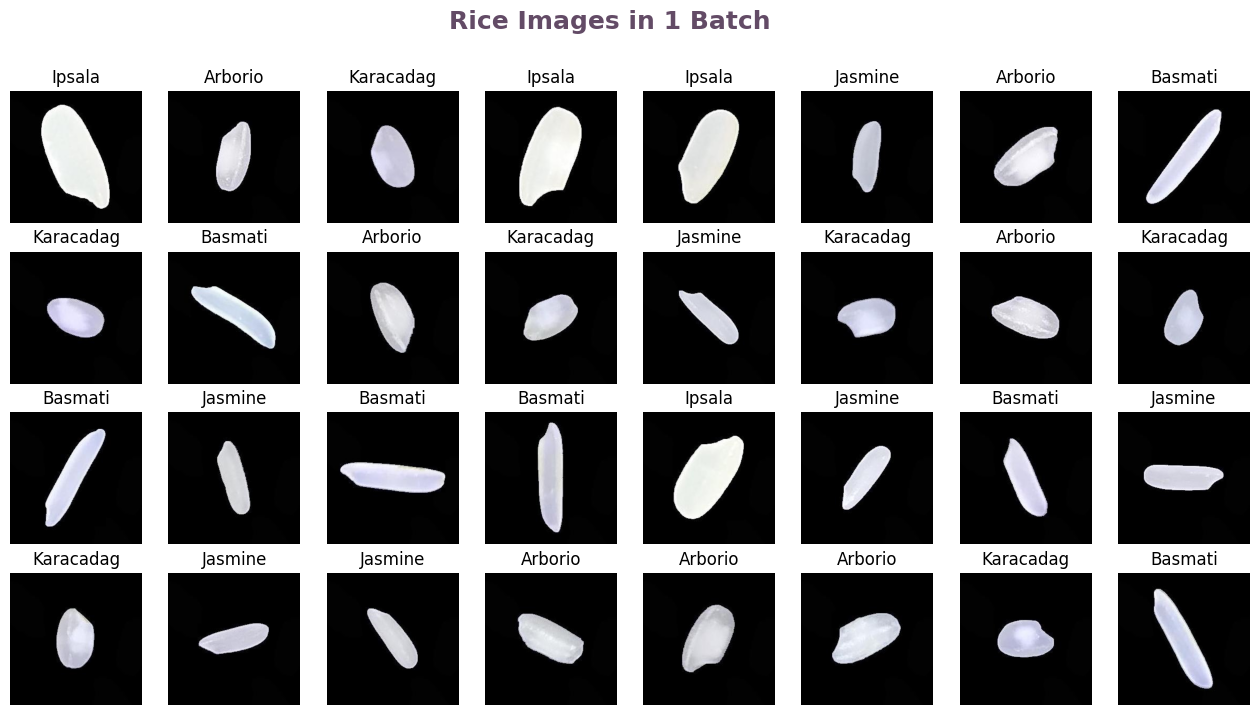

In [6]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(16, 8))
plt.suptitle('Rice Images in 1 Batch', fontsize=18, fontweight='bold', color='#634b66')

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(batch_images[i], (1, 2, 0))
    plt.imshow(img)

    label = rice_variety_labels[int(labels[i])]

    plt.title(label)
    plt.axis('off')
plt.show()

In [7]:
import numpy as np  
import pandas as pd 

image_data = []

for dataset_type in ['train', 'val', 'test']:
    dataset_dir = dir2 / dataset_type

    for class_name in os.listdir(dataset_dir):
        class_dir = dataset_dir / class_name
        image_files = os.listdir(class_dir)

        for image_file in image_files:
            image_path = class_dir / image_file
            image_data.append((str(image_path), class_name))

df = pd.DataFrame(image_data, columns=['path', 'label'])

df = df.sample(frac=1).reset_index(drop=True)

display(df.head())

,path,label
0,C:\Users\park9\pytorch\AI_class\pytorch_study\...,Basmati
1,C:\Users\park9\pytorch\AI_class\pytorch_study\...,Basmati
2,C:\Users\park9\pytorch\AI_class\pytorch_study\...,Ipsala
3,C:\Users\park9\pytorch\AI_class\pytorch_study\...,Ipsala
4,C:\Users\park9\pytorch\AI_class\pytorch_study\...,Ipsala


In [8]:
import torch.nn as nn 

class CNN(nn.Module):
    def __init__(self, unique_classes):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(107648, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, unique_classes)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

model = CNN(unique_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=107648, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, ou

In [9]:
from torchsummary import summary
summary(model, (3, 250, 250));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 29, 29]         --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 124, 124]        64
|    └─Conv2d: 2-5                       [-1, 64, 122, 122]        18,496
|    └─ReLU: 2-6                         [-1, 64, 122, 122]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 61, 61]          --
|    └─BatchNorm2d: 2-8                  [-1, 64, 61, 61]          128
|    └─Conv2d: 2-9                       [-1, 128, 59, 59]         73,856
|    └─ReLU: 2-10                        [-1, 128, 59, 59]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 29, 29]         --
|    └─BatchNorm2d: 2-12                 [-1, 128, 29, 29]         256
├─Se

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

In [11]:
import torch
import numpy as np

for epoch in range(num_epochs):
    # ----- Train -----
    model.train()
    train_loss_sum = 0.0
    train_samples  = 0
    n_correct_train = 0
    n_total_train   = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        # 손실(가중 평균)
        bs = labels.size(0)
        train_loss_sum += loss.item() * bs
        train_samples  += bs

        # 정확도
        preds = y_pred.argmax(1)
        n_correct_train += (preds == labels).sum().item()
        n_total_train   += bs

    train_loss = train_loss_sum / train_samples
    train_acc  = n_correct_train / n_total_train
    train_losses[epoch] = train_loss
    train_accs[epoch]   = train_acc

    # ----- Val -----
    model.eval()
    val_loss_sum = 0.0
    val_samples  = 0
    n_correct_val = 0
    n_total_val   = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            bs = labels.size(0)
            val_loss_sum += loss.item() * bs
            val_samples  += bs

            preds = y_pred.argmax(1)
            n_correct_val += (preds == labels).sum().item()
            n_total_val   += bs

    val_loss = val_loss_sum / val_samples
    val_acc  = n_correct_val / n_total_val
    val_losses[epoch] = val_loss
    val_accs[epoch]   = val_acc

    print(
        f"Epoch [{epoch+1}/{num_epochs}]\n"
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\n"
        f"Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_acc:.4f}"
    )

Epoch [1/5]
Train Loss: 0.2541, Train Accuracy: 0.9169
Val   Loss: 0.1514, Val   Accuracy: 0.9524
Epoch [2/5]
Train Loss: 0.0790, Train Accuracy: 0.9749
Val   Loss: 0.0313, Val   Accuracy: 0.9931
Epoch [3/5]
Train Loss: 0.0664, Train Accuracy: 0.9804
Val   Loss: 0.2143, Val   Accuracy: 0.9200
Epoch [4/5]
Train Loss: 0.0537, Train Accuracy: 0.9837
Val   Loss: 0.0214, Val   Accuracy: 0.9938
Epoch [5/5]
Train Loss: 0.0467, Train Accuracy: 0.9874
Val   Loss: 0.0261, Val   Accuracy: 0.9932


In [13]:
with torch.no_grad():
    model.eval()
    test_loss = []
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        # Move images and labels to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get predictions
        predictions = model(images)
        loss = criterion(predictions, labels)

        # Append loss to test_loss list
        test_loss.append(loss.item())

        # Calculate number of correct predictions
        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    # Compute average test loss and accuracy
    avg_test_loss = np.mean(test_loss)
    test_accuracy = total_correct / total_samples

    # Print the results with custom formatting
    print(f'Loss: {avg_test_loss:.4f}\nAccuracy: {test_accuracy:.4f}')

Loss: 0.0241
Accuracy: 0.9925
